In [117]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras import regularizers
from keras.losses import MSE
from keras.backend import mean

In [86]:
DATA_PATH = './1950-2018_torn_preprocessed.csv'
LEARNING_RATE = 0.001
EPOCHS = 10
BATCH_SIZE = 256

In [88]:
def plot_loss_accuracy(history):
    plt.figure(figsize=(20,10))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

# Data imported is preprocessed
### check out the notebook Feature Engineering to see what was done

In [73]:
#### load data
data = pd.read_csv(DATA_PATH, usecols=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
data.tail()

,tz,stf,mag,inj,fat,loss,closs,slat,slon,elat,elon,len,wid,day_rad,time_rad
64709,3,22,1,0,0,7000.0,0.0,30.1302,-92.3645,30.1321,-92.3547,0.60,25,6.214328,2.683444
64710,3,28,0,0,0,15000.0,0.0,32.6431,-90.4509,32.6427,-90.4288,1.29,100,6.214328,2.744530
64711,3,21,1,0,0,55000.0,0.0,36.8900,-87.9870,36.8915,-87.9734,0.76,125,6.283185,3.294309
64712,3,18,1,0,0,50000.0,0.0,38.1813,-86.8863,38.2006,-86.8585,2.01,50,6.283185,3.591015
64713,3,18,1,0,0,20000.0,0.0,38.0935,-86.0869,38.1000,-86.0470,2.20,140,6.283185,3.830998


### Split the data for training and testing
#### 90% training and 10% test
Training data will be further split into training and validation

In [46]:
train, test = train_test_split(data, test_size=0.10, random_state=1)

In [47]:
test.head()

,tz,stf,mag,inj,fat,loss,closs,slat,slon,elat,elon,len,wid,day_rad,time_rad
41332,3,22,1,5,0,0.1,0.0,30.0800,-93.2000,30.0700,-93.2000,5.00,20,1.618135,1.090831
11575,3,55,1,0,0,5.0,0.0,42.7000,-89.0000,0.0000,0.0000,0.50,100,3.046915,4.537856
17521,3,42,0,0,0,3.0,0.0,40.4300,-79.9800,0.0000,0.0000,0.10,10,1.996848,3.381575
44752,3,47,2,10,0,50.0,0.0,36.0000,-89.4200,36.1200,-89.2700,15.00,200,2.134562,5.759587
57819,3,12,0,0,0,0.0,0.0,29.0348,-82.7569,29.0561,-82.7168,2.84,200,2.582131,3.198316


## Since this is a multiple output model we will be using two neural nets so we can have two seperate loss functions
One for Ending Latitude(elat) and another for Ending Longitude(elon)

# Longitude

In [102]:
train_lon = train#.drop(['elon'], axis=1)
test_lon = test.drop(['elat'], axis=1)
test_lon_labels = test_lon['elon'].values

## Split the training data into training and validation set
### 80% training and 20% validation

In [103]:
train_lon, validation_lon = train_test_split(train_lon, test_size=0.20, random_state=1)
train_lon.head()

,tz,stf,mag,inj,fat,loss,closs,slat,slon,elat,elon,len,wid,day_rad,time_rad
22029,3,20,1,0,0,0.000,0.0,39.05,-99.88,0.00,0.00,0.50,17,3.442841,5.497787
52758,3,28,0,0,0,0.005,0.0,31.78,-89.10,31.79,-89.10,0.73,25,4.234695,2.177298
5614,3,29,2,0,0,5.000,0.0,36.62,-93.38,36.72,-93.12,16.30,50,1.222209,4.712389
13669,3,48,1,0,0,0.000,0.0,36.07,-102.55,0.00,0.00,0.10,10,2.255061,4.297873
12389,3,42,1,5,0,6.000,0.0,40.68,-80.33,40.68,-80.28,1.30,200,4.234695,4.830199


### Drop the predictor variables from the training and validation data
 train_df and validation_df look very similar but had to do it twice, so after splitting instead of before training and validation split is because there is a random_state to the data split and thus would lose information on what output value belongs to what row of data

In [104]:
train_lon_labels = train_lon['elon'].values
validation_lon_labels = validation_lon['elon'].values
train_lon_df = train_lon.drop(['elon'], axis=1)
validation_lon_df = validation_lon.drop(['elon'], axis=1)
validation_lon_df.head() 

,tz,stf,mag,inj,fat,loss,closs,slat,slon,elat,len,wid,day_rad,time_rad
20227,3,8,0,0,0,2.00,0.0,39.38,-104.77,0.0,1.0,50,3.408413,4.516039
48658,3,28,0,0,0,0.01,0.0,33.70,-90.67,33.7,1.0,100,4.596193,4.341507
13352,3,25,1,0,0,3.00,0.0,42.47,-72.00,0.0,0.1,27,5.353618,2.356194
25546,3,27,0,0,0,0.00,0.0,48.60,-94.80,0.0,0.2,10,2.737059,3.015056
1171,3,37,1,0,0,4.00,0.0,35.20,-80.00,35.3,16.6,27,0.895139,2.574361


In [105]:
test_lon.head()

,tz,stf,mag,inj,fat,loss,closs,slat,slon,elon,len,wid,day_rad,time_rad
41332,3,22,1,5,0,0.1,0.0,30.0800,-93.2000,-93.2000,5.00,20,1.618135,1.090831
11575,3,55,1,0,0,5.0,0.0,42.7000,-89.0000,0.0000,0.50,100,3.046915,4.537856
17521,3,42,0,0,0,3.0,0.0,40.4300,-79.9800,0.0000,0.10,10,1.996848,3.381575
44752,3,47,2,10,0,50.0,0.0,36.0000,-89.4200,-89.2700,15.00,200,2.134562,5.759587
57819,3,12,0,0,0,0.0,0.0,29.0348,-82.7569,-82.7168,2.84,200,2.582131,3.198316


Scale the data using scikitlearn scaler

In [106]:
# Scale Data
scaler_lon = preprocessing.MinMaxScaler()
train_lon_df_scaled = scaler_lon.fit_transform(train_lon_df)
validation_lon_df_scaled = scaler_lon.transform(validation_lon_df)
test_lon_scaled = scaler_lon.transform(test_lon)

/Users/Vineeth/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


## Initialize feed forward neural network for predicting ending longitude

In [107]:
model_lon = Sequential()
model_lon.add(Dense(256, activation='relu', input_dim=train_lon_df_scaled.shape[1], activity_regularizer=regularizers.l1(0.01)))
model_lon.add(BatchNormalization())
model_lon.add(Dense(128, activation='relu'))
model_lon.add(BatchNormalization())
model_lon.add(Dense(64, activation='relu'))
model_lon.add(BatchNormalization())
model_lon.add(Dense(32, activation='relu'))
model_lon.add(BatchNormalization())
model_lon.add(Dense(8, activation='relu'))
model_lon.add(BatchNormalization())
model_lon.add(Dense(1))

adam = optimizers.adam(lr=LEARNING_RATE)
model_lon.compile(loss='mse', optimizer=adam, metrics=['mae'])

In [108]:
model_lon.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 256)               3840      
_________________________________________________________________
batch_normalization_21 (Batc (None, 256)               1024      
_________________________________________________________________
dense_26 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_22 (Batc (None, 128)               512       
_________________________________________________________________
dense_27 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_23 (Batc (None, 64)                256       
_________________________________________________________________
dense_28 (Dense)             (None, 32)                2080      
__________

In [109]:
trained_lon = model_lon.fit(x=train_lon_df_scaled, y=train_lon_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, 
                    verbose=1, validation_data=(validation_lon_df_scaled, validation_lon_labels), 
                    shuffle=True)

Train on 46593 samples, validate on 11649 samples
Epoch 1/10
46593/46593 [==============================] - 3s 75us/step - loss: 4686.7146 - mean_absolute_error: 54.1483 - val_loss: 4422.2211 - val_mean_absolute_error: 53.6279
Epoch 2/10
46593/46593 [==============================] - 3s 57us/step - loss: 4248.1693 - mean_absolute_error: 52.5713 - val_loss: 3833.0866 - val_mean_absolute_error: 50.7641
Epoch 3/10
46593/46593 [==============================] - 2s 52us/step - loss: 3697.8595 - mean_absolute_error: 50.0765 - val_loss: 3270.6333 - val_mean_absolute_error: 47.7709
Epoch 4/10
46593/46593 [==============================] - 2s 52us/step - loss: 3062.1203 - mean_absolute_error: 46.7053 - val_loss: 2687.7768 - val_mean_absolute_error: 44.4122
Epoch 5/10
46593/46593 [==============================] - 2s 53us/step - loss: 2405.6710 - mean_absolute_error: 42.5918 - val_loss: 2123.3035 - val_mean_absolute_error: 40.9043
Epoch 6/10
46593/46593 [==============================] - 2s 53us

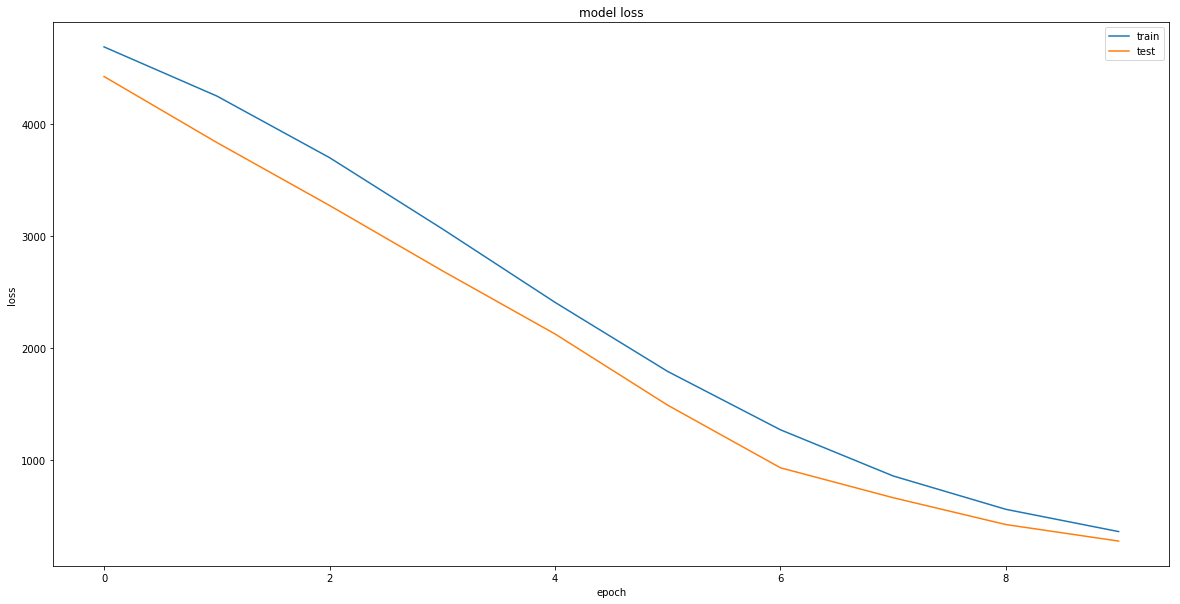

In [110]:
plot_loss_accuracy(trained_lon)

In [111]:
prediction_lon = model_lon.predict(test_lon_scaled, batch_size=128, verbose=1)

6472/6472 [==============================] - 0s 76us/step


In [114]:
prediction_lon_errors = MSE(test_lon_labels, prediction_lon)

In [118]:
mean(prediction_lon_errors)

<tf.Tensor 'Mean_2:0' shape=() dtype=float64>

# Latitude

In [119]:
train_lat = train
test_lat = test.drop(['elon'], axis=1)
test_lat_labels = test_lat['elat'].values

## Again split the training data into training and validation set
### 80% training and 20% validation

In [120]:
train_lat, validation_lat = train_test_split(train_lat, test_size=0.20, random_state=1)
train_lat.head()

,tz,stf,mag,inj,fat,loss,closs,slat,slon,elat,elon,len,wid,day_rad,time_rad
22029,3,20,1,0,0,0.000,0.0,39.05,-99.88,0.00,0.00,0.50,17,3.442841,5.497787
52758,3,28,0,0,0,0.005,0.0,31.78,-89.10,31.79,-89.10,0.73,25,4.234695,2.177298
5614,3,29,2,0,0,5.000,0.0,36.62,-93.38,36.72,-93.12,16.30,50,1.222209,4.712389
13669,3,48,1,0,0,0.000,0.0,36.07,-102.55,0.00,0.00,0.10,10,2.255061,4.297873
12389,3,42,1,5,0,6.000,0.0,40.68,-80.33,40.68,-80.28,1.30,200,4.234695,4.830199


### Drop the predictor variables from the training and validation data

In [121]:
train_lat_labels = train_lon['elat'].values
validation_lat_labels = validation_lat['elat'].values
train_lat_df = train_lat.drop(['elat'], axis=1)
validation_lat_df = validation_lat.drop(['elat'], axis=1)
validation_lat_df.head() 

,tz,stf,mag,inj,fat,loss,closs,slat,slon,elon,len,wid,day_rad,time_rad
20227,3,8,0,0,0,2.00,0.0,39.38,-104.77,0.00,1.0,50,3.408413,4.516039
48658,3,28,0,0,0,0.01,0.0,33.70,-90.67,-90.67,1.0,100,4.596193,4.341507
13352,3,25,1,0,0,3.00,0.0,42.47,-72.00,0.00,0.1,27,5.353618,2.356194
25546,3,27,0,0,0,0.00,0.0,48.60,-94.80,0.00,0.2,10,2.737059,3.015056
1171,3,37,1,0,0,4.00,0.0,35.20,-80.00,-79.73,16.6,27,0.895139,2.574361


In [122]:
test_lat.head()

,tz,stf,mag,inj,fat,loss,closs,slat,slon,elat,len,wid,day_rad,time_rad
41332,3,22,1,5,0,0.1,0.0,30.0800,-93.2000,30.0700,5.00,20,1.618135,1.090831
11575,3,55,1,0,0,5.0,0.0,42.7000,-89.0000,0.0000,0.50,100,3.046915,4.537856
17521,3,42,0,0,0,3.0,0.0,40.4300,-79.9800,0.0000,0.10,10,1.996848,3.381575
44752,3,47,2,10,0,50.0,0.0,36.0000,-89.4200,36.1200,15.00,200,2.134562,5.759587
57819,3,12,0,0,0,0.0,0.0,29.0348,-82.7569,29.0561,2.84,200,2.582131,3.198316


Scale the data

In [123]:
scaler_lat = preprocessing.MinMaxScaler()
train_lat_df_scaled = scaler_lat.fit_transform(train_lat_df)
validation_lat_df_scaled = scaler_lat.transform(validation_lat_df)
test_lat_scaled = scaler_lat.transform(test_lat)

/Users/Vineeth/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


## Initialize feed forward neural network for predicting ending latitude

In [124]:
model_lat = Sequential()
model_lat.add(Dense(256, activation='relu', input_dim=train_lat_df_scaled.shape[1], activity_regularizer=regularizers.l1(0.01)))
model_lat.add(BatchNormalization())
model_lat.add(Dense(128, activation='relu'))
model_lat.add(BatchNormalization())
model_lat.add(Dense(64, activation='relu'))
model_lat.add(BatchNormalization())
model_lat.add(Dense(32, activation='relu'))
model_lat.add(BatchNormalization())
model_lat.add(Dense(8, activation='relu'))
model_lat.add(BatchNormalization())
model_lat.add(Dense(1))

adam = optimizers.adam(lr=LEARNING_RATE)
model_lat.compile(loss='mse', optimizer=adam, metrics=['mae'])

In [126]:
model_lat.summary() # same as one for longitude

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 256)               3840      
_________________________________________________________________
batch_normalization_26 (Batc (None, 256)               1024      
_________________________________________________________________
dense_32 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_27 (Batc (None, 128)               512       
_________________________________________________________________
dense_33 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_28 (Batc (None, 64)                256       
_________________________________________________________________
dense_34 (Dense)             (None, 32)                2080      
__________

In [127]:
trained_lat = model_lat.fit(x=train_lat_df_scaled, y=train_lat_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, 
                    verbose=1, validation_data=(validation_lat_df_scaled, validation_lat_labels), 
                    shuffle=True)

Train on 46593 samples, validate on 11649 samples
Epoch 1/10
46593/46593 [==============================] - 15s 326us/step - loss: 701.9990 - mean_absolute_error: 21.6409 - val_loss: 599.9731 - val_mean_absolute_error: 19.0634
Epoch 2/10
46593/46593 [==============================] - 3s 59us/step - loss: 555.6436 - mean_absolute_error: 20.1849 - val_loss: 442.8770 - val_mean_absolute_error: 18.2384
Epoch 3/10
46593/46593 [==============================] - 3s 62us/step - loss: 399.1395 - mean_absolute_error: 17.9738 - val_loss: 347.8627 - val_mean_absolute_error: 17.2595
Epoch 4/10
46593/46593 [==============================] - 3s 58us/step - loss: 257.8362 - mean_absolute_error: 15.1936 - val_loss: 199.9550 - val_mean_absolute_error: 13.8044
Epoch 5/10
46593/46593 [==============================] - 3s 54us/step - loss: 154.3233 - mean_absolute_error: 12.1726 - val_loss: 127.6233 - val_mean_absolute_error: 11.1647
Epoch 6/10
46593/46593 [==============================] - 3s 65us/step - 

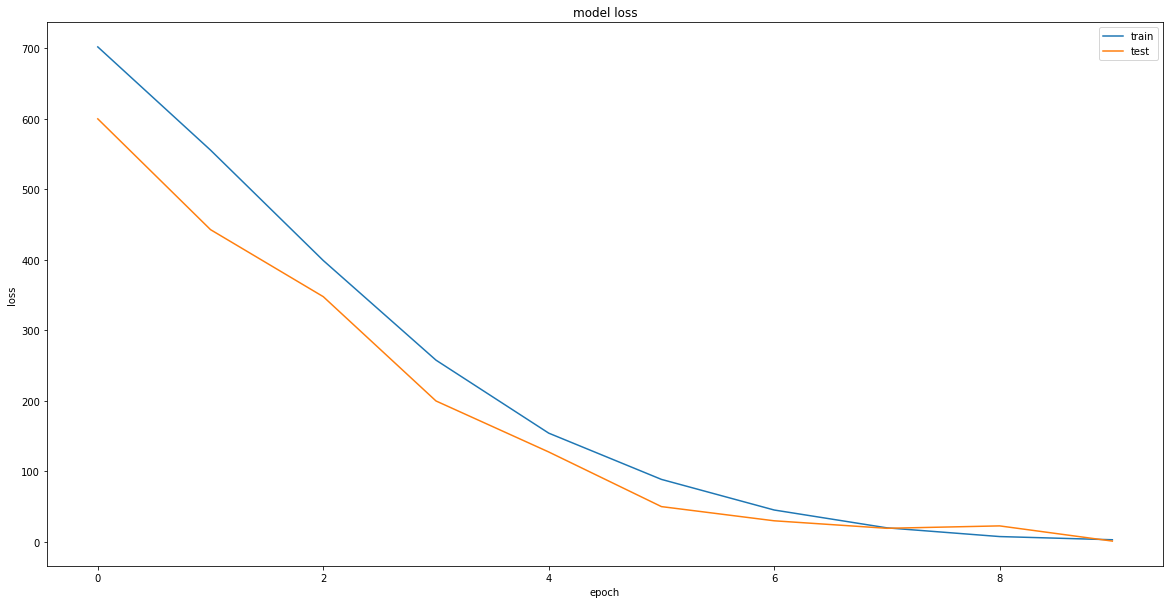

In [128]:
plot_loss_accuracy(trained_lat)

In [129]:
prediction_lat = model_lat.predict(test_lat_scaled, batch_size=128, verbose=1)

6472/6472 [==============================] - 4s 670us/step
